In [1]:
import pandas as pd


df = pd.read_csv('sensor_data.csv')


df['timestamp'] = pd.date_range(start='2024-01-24', periods=len(df), freq='H')


df.to_csv('sensor_data_updated.csv', index=False)


/tmp/ipython-input-1-1079448153.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2024-01-24', periods=len(df), freq='H')


In [3]:
df = pd.read_csv('/content/sensor_data_updated.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df.head()

,timestamp,machine_id,temperature,vibration,pressure,failure
0,2024-01-24 00:00:00,M3,75.485216,0.508841,23.244628,0
1,2024-01-24 01:00:00,M1,66.690499,0.647753,23.387710,0
2,2024-01-24 02:00:00,M3,77.704568,0.385831,32.409330,0
3,2024-01-24 03:00:00,M3,74.497619,0.480634,32.736324,0
4,2024-01-24 04:00:00,M1,72.610520,0.428318,32.744419,0


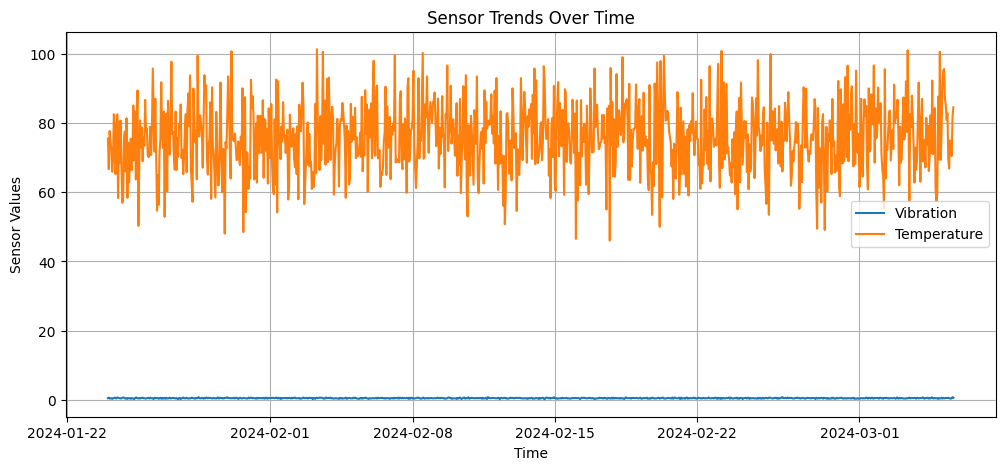

failure
0    944
1     56
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['vibration'], label='Vibration')
plt.plot(df['timestamp'], df['temperature'], label='Temperature')
plt.legend()
plt.title("Sensor Trends Over Time")
plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.grid(True)
plt.show()

print(df['failure'].value_counts())


In [5]:
df['vibration_mean_3'] = df['vibration'].rolling(window=3).mean()
df['temperature_mean_3'] = df['temperature'].rolling(window=3).mean()

df['vibration_diff'] = df['vibration'].diff()
df['temperature_diff'] = df['temperature'].diff()

df = df.dropna()


In [6]:
from sklearn.model_selection import train_test_split

features = ['vibration', 'temperature', 'vibration_mean_3', 'temperature_mean_3', 'vibration_diff', 'temperature_diff']
X = df[features]
y = df['failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[188   1]
 [ 11   0]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       189
           1       0.00      0.00      0.00        11

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.89      0.94      0.92       200



In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

SEQ_LEN = 30

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X.iloc[i:i+seq_len].values)
        ys.append(y.iloc[i+seq_len])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_sequences(X, y, SEQ_LEN)
X_train_lstm, X_test_lstm = X_lstm[:int(0.8*len(X_lstm))], X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm, y_test_lstm = y_lstm[:int(0.8*len(y_lstm))], y_lstm[int(0.8*len(y_lstm)):]


model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(SEQ_LEN, len(features))))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64)

loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f'LSTM Test Accuracy: {accuracy:.2f}')


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6717 - loss: 0.6098
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9535 - loss: 0.3023
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9599 - loss: 0.1887
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9591 - loss: 0.1720
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9528 - loss: 0.1888
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9583 - loss: 0.1728
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9631 - loss: 0.1575
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9428 - loss: 0.2199
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9536 - loss: 0.1867
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9544 - loss: 0.1833
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9166 - loss: 0.3010  
LSTM Test Accuracy: 0.91
